In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing Libraries
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from PIL import Image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [3]:
# Load dataset directories
train = 'FER/train'
test = 'FER/test'

In [4]:
img_size=(48,48)
bth_size=32

# Augmenting Images for training set

trdatagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.1
)

# Normalization of the pixel values for test Set
tedatagen = ImageDataGenerator(rescale=1.0/255)

In [5]:
# Reading the training data from directory

traingen= trdatagen.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale',  
    class_mode='categorical',
    shuffle=True,
    subset='training')

# Reading the testing data from directory

testgen = tedatagen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=bth_size,
    color_mode='grayscale', 
    class_mode='categorical',
    shuffle=False
)

Found 25841 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


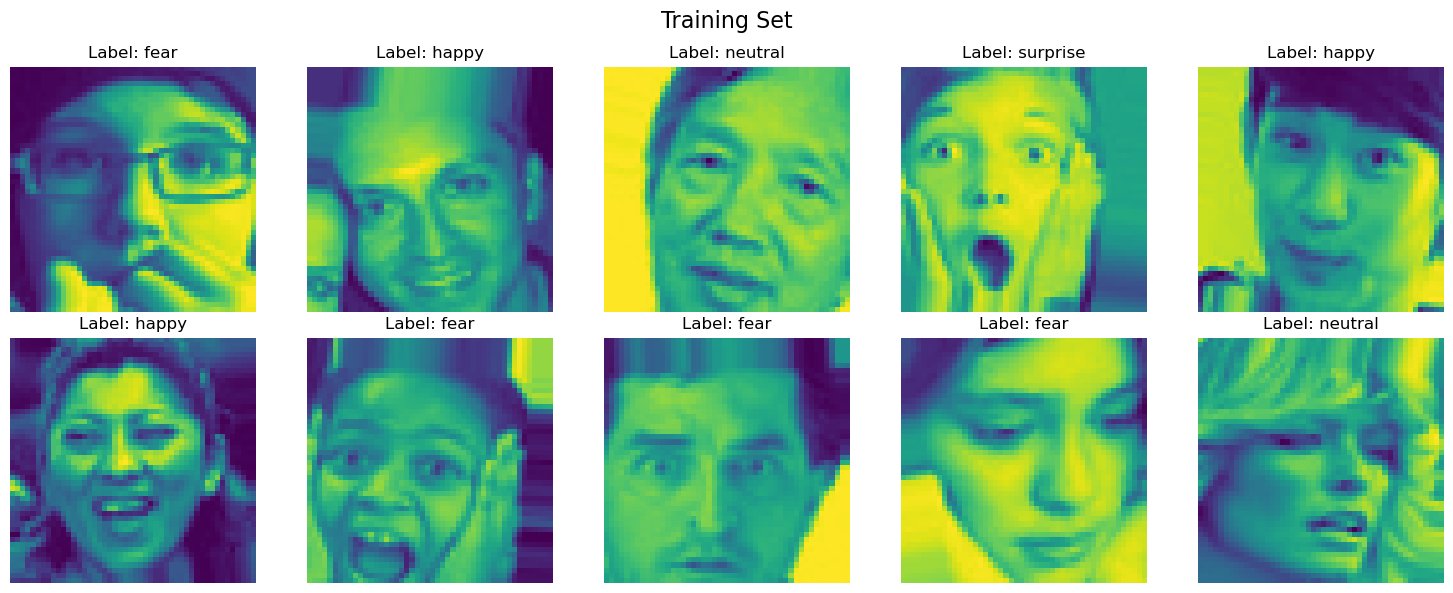

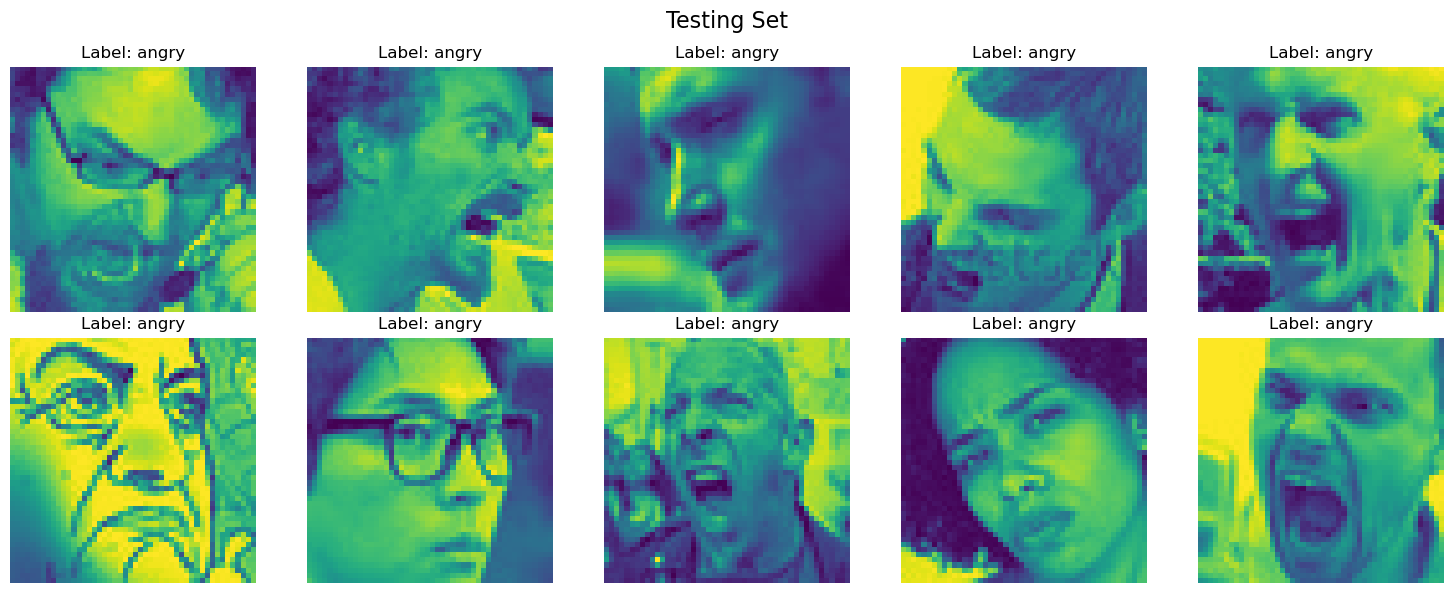

In [6]:
# Displaying the training and testing datsets (only 5 images from each dataset)

def plot_images_from_generator(generator, title, num_images=5, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traingen, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testgen, "Testing Set", num_images=10, images_per_row=5)

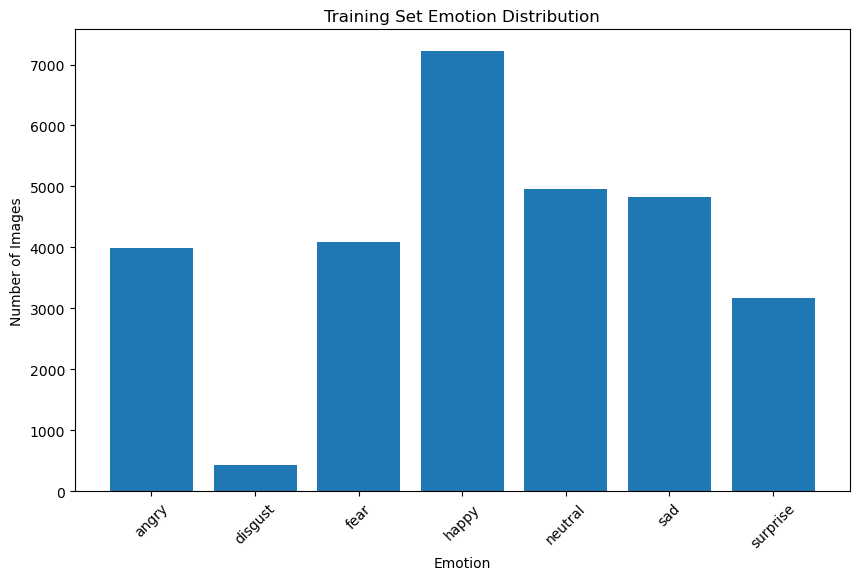

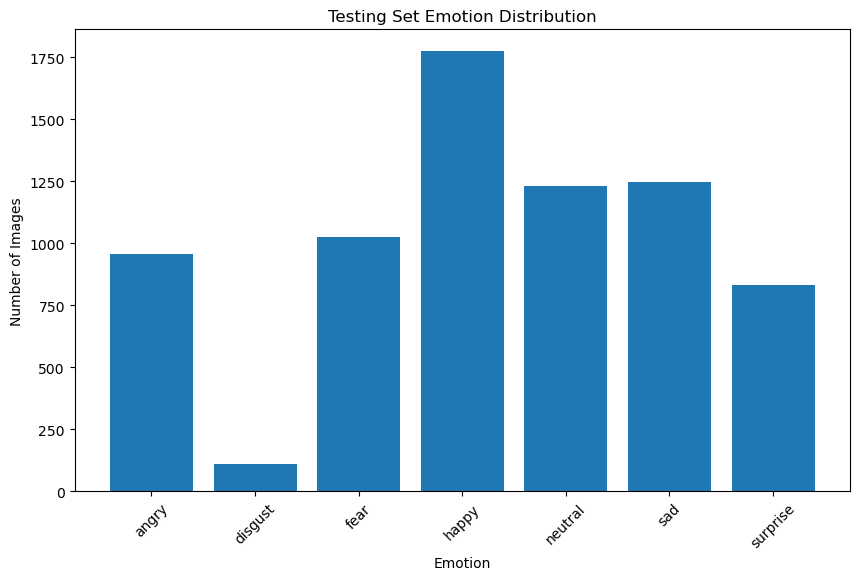

In [7]:
#class distribution

def plot_class_distribution(directory, title):
    class_names = os.listdir(directory)
    class_counts = []
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts.append(len(os.listdir(class_dir)))

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Emotion')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution('FER/train', "Training Set Emotion Distribution")
plot_class_distribution('FER/test', "Testing Set Emotion Distribution")

In [8]:
# Label Map
label_map = {
    0:'Angry', 
    1:'Disgust',
    2:'Fear',
    3:'Happy', 
    4:'Sad', 
    5:'Surprise', 
    6:'Neutral'
}

In [9]:
# Learning rate schedule for better training control
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=0.001)

In [10]:
# Defining CNN model

model = Sequential()
model.add(Input(shape=(48, 48, 1)))

# Block 1
model.add(SeparableConv2D(64, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(64, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(SeparableConv2D(128, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(128, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(SeparableConv2D(256, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(256, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 4
model.add(SeparableConv2D(512, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(SeparableConv2D(512, (3, 3), padding='same',
                          depthwise_initializer='he_normal', pointwise_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout for better regularization

model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 48, 48, 64)     │           137 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 48, 48, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 24, 24, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 24, 24, 128)    │        17,664 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 12, 12, 256)    │        34,176 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 12, 12, 256)    │        68,09

 Total params: 2,907,984 (11.09 MB)

 Trainable params: 2,903,120 (11.07 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [11]:
#Implementing Early Stopping and Learning Rate Reduction
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [12]:
history = model.fit(
    traingen,
    epochs=100,
    validation_data=testgen,
    callbacks=callbacks_list
)

Epoch 1/100


C:\Users\RAVI RAJ\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


808/808 ━━━━━━━━━━━━━━━━━━━━ 121s 145ms/step - accuracy: 0.2134 - loss: 2.1616 - val_accuracy: 0.2732 - val_loss: 1.8400 - learning_rate: 0.0010
Epoch 2/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 96s 119ms/step - accuracy: 0.2790 - loss: 1.8011 - val_accuracy: 0.3257 - val_loss: 1.7010 - learning_rate: 0.0010
Epoch 3/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 96s 119ms/step - accuracy: 0.3509 - loss: 1.6498 - val_accuracy: 0.4308 - val_loss: 1.5166 - learning_rate: 0.0010
Epoch 4/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 96s 119ms/step - accuracy: 0.4194 - loss: 1.5011 - val_accuracy: 0.4758 - val_loss: 1.3906 - learning_rate: 0.0010
Epoch 5/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 96s 119ms/step - accuracy: 0.4489 - loss: 1.4272 - val_accuracy: 0.4533 - val_loss: 1.3676 - learning_rate: 0.0010
Epoch 6/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 96s 119ms/step - accuracy: 0.4738 - loss: 1.3728 - val_accuracy: 0.5120 - val_loss: 1.3018 - learning_rate: 0.0010
Epoch 7/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 97s 120ms/step - accuracy: 0.4929 

In [13]:
#Predicting
test_loss, test_accuracy = model.evaluate(testgen)

225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - accuracy: 0.6069 - loss: 1.0294


Test Accuracy: 0.64
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.60      0.56       958
           1       0.73      0.34      0.47       111
           2       0.55      0.34      0.42      1024
           3       0.86      0.87      0.87      1774
           4       0.52      0.73      0.61      1233
           5       0.56      0.44      0.49      1247
           6       0.74      0.80      0.77       831

    accuracy                           0.64      7178
   macro avg       0.64      0.59      0.60      7178
weighted avg       0.65      0.64      0.64      7178

Confusion Matrix:
[[ 577   10   55   35  164   87   30]
 [  47   38    3    4    7    8    4]
 [ 168    2  352   37  157  188  120]
 [  37    1   29 1543  108   23   33]
 [  79    0   35   69  900  124   26]
 [ 147    0  108   61  360  550   21]
 [  31    1   60   41   21    9  668]] 




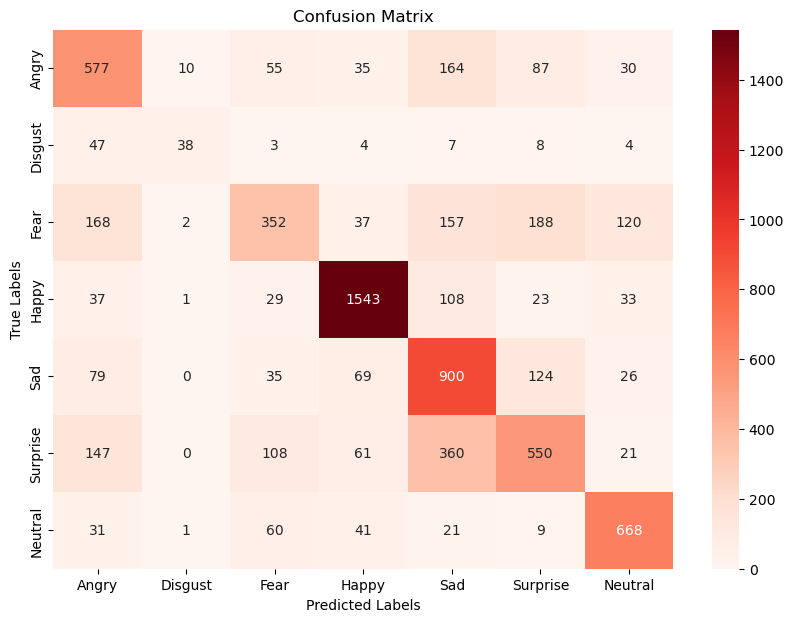

Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [14]:
print(f"Test Accuracy: {test_accuracy:.2f}")
y_pred = np.argmax(model.predict(testgen), axis=1)
y_true = testgen.classes
print("Classification Report:")
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix,'\n\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=list(label_map.values()), 
            yticklabels=list(label_map.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Training class indices:", traingen.class_indices)
print("Test class indices:", testgen.class_indices)

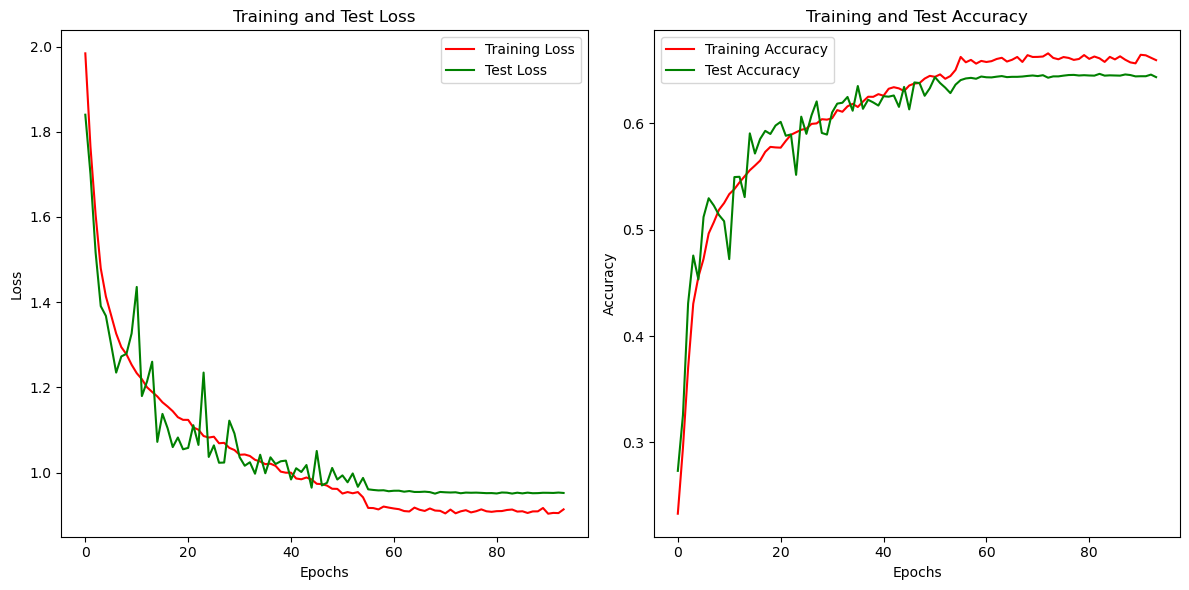

In [15]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Test Loss', color='green')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='green')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step


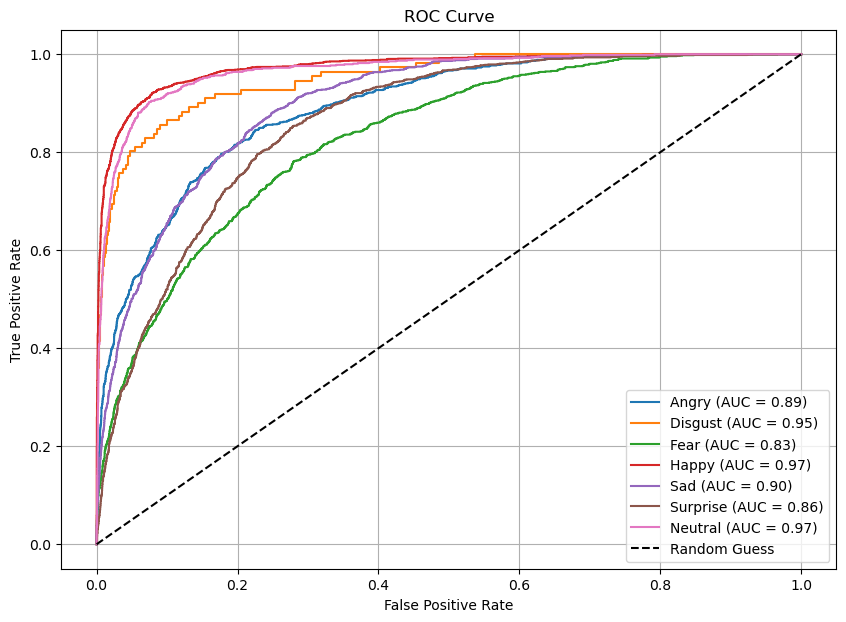

In [16]:
# Convert true labels to one-hot encoding for ROC calculations
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2, 3, 4,5,6])
y_pred_prob = model.predict(testgen)

plt.figure(figsize=(10, 7))

# Plot ROC for each class
for i, class_name in label_map.items():
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()